##### Esboço para a analise



Utilizando modelo de black scholes e calculando a vol implicita de mercado minimizando a MQO ponderada temos

A idéia então é minimizar o erro quadrático médio do mercado e encontrar essas duas váriaveis

In [360]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
import warnings
import yfinance as yf
from scipy import stats

#Black Scholes option call precification
def black_scholes_call(S, K, T, r, sigma):
    '''black_scholes_call(S, K, T, r, sigma)
    S: spot price
    K: strike price
    T: time to maturity
    r: interest rate
    sigma: volatility of underlying asset
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = (S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))

    if T < 1/250:
        call = S - K
        call = np.where(call < 0, 0, call)
    return call


#Black Scholes option greek delta
def bs_call_delta(S,K,T,r,sigma):
    '''bs_call_delta(S,K,T,r,sigma)
    S: spot price
    K: strike price
    T: time to maturity
    r: interest rate
    sigma: volatility of underlying asset
    '''
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    delta = stats.norm.cdf(d1, 0.0, 1.0)
    return delta


### abrrir o arquivo  options.csv

opcs = pd.read_csv('opcs.csv', encoding='ANSI')
opcs


,Under,Strike,Venc,Tipo,Preço,Volume
0,AAAA3,25,365,Call,77.022029,260800
1,AAAA3,26,365,Call,77.556945,274000
2,AAAA3,27,365,Call,77.339647,282500
3,AAAA3,28,365,Call,74.264279,297700
4,AAAA3,29,365,Call,75.016137,302400
...,...,...,...,...,...,...
145,AAAA3,170,365,Call,0.589886,298500
146,AAAA3,171,365,Call,2.364003,292400
147,AAAA3,172,365,Call,0.120545,281300
148,AAAA3,173,365,Call,1.111372,282300


c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

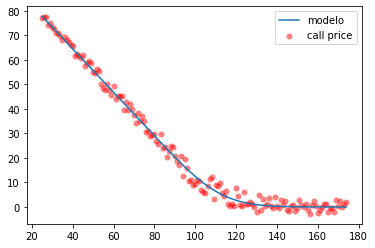

In [357]:

from scipy.optimize import minimize


teste = opcs.sample(150)

X = teste['Strike'].values
Y = teste['Preço'].values
weight = teste['Volume'].values / teste['Volume'].sum()


price = 100
r = 0.12
maturity = 1



def error(params):
    sigma, add_price = params
    call_modelo = black_scholes_call(price+add_price,teste['Strike'].values, maturity, r, sigma)
    mqo = (Y - call_modelo)**2
    mqo = (mqo * weight).mean()

    return mqo

targuet = [.9,0.0]

resultado = minimize(error, targuet, method='Nelder-Mead')
sigma, add_price = resultado.x

## Teste

X = opcs['Strike'].values
Y = opcs['Preço'].values

call_modelo = black_scholes_call(price+add_price, X, maturity, r, sigma)

plt.plot(X, call_modelo, label='modelo')
sns.scatterplot(X, Y, label='call price', linewidth=0, alpha=0.5, color='red')




In [366]:
opcs['Black-Scholes'] = call_modelo
opcs['Delta'] = bs_call_delta(price, opcs['Strike'], opcs['Venc']/365, 0.12, sigma)
opcs['Weight'] = np.random.normal(0, 1, size = len(opcs))**2
opcs['Weight'] = (opcs['Black-Scholes']-opcs['Preço'])*opcs['Delta']*opcs['Volume']
opcs['Weight'] = opcs['Weight']/sum(abs(opcs['Weight']))


C:\Users\diogo\AppData\Local\Temp\ipykernel_19020\646385672.py:22: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
C:\Users\diogo\AppData\Local\Temp\ipykernel_19020\646385672.py:23: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
C:\Users\diogo\AppData\Local\Temp\ipykernel_19020\646385672.py:41: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))


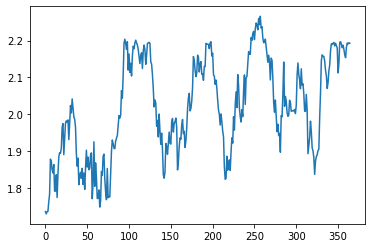

In [385]:
#Criando o passeio aleatório para o ativo ficticio AAAA3

cota = np.random.normal(1, 0.0094, 365).cumprod()
cota = cota*100/cota[0]

carteira = pd.DataFrame(cota, columns=['AAAA3'])


for i,spot in enumerate(cota) :
    px_carteira = black_scholes_call(spot, opcs['Strike'], (maturity-i)/365, r, sigma)
    px_carteira = (px_carteira - opcs['Preço']) * opcs['Weight']
    payoff = px_carteira.sum()
    
    delta_carteira = bs_call_delta(spot, opcs['Strike'], (maturity-i)/365, r, sigma)
    delta_carteira = delta * opcs['Weight']
    exposicao = delta_carteira.sum()

    carteira.loc[i,'Payoff'] = payoff
    carteira.loc[i,'Exposicao'] = exposicao

plt.plot(carteira['Payoff'])



